In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [62]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression

### Define Dimensions

* we choose an underdetermined where N << d

In [234]:
N = 5
d = 25

### Define Dataset

* to make sure the data is realizable by a linear model we create the y using a fitter linear regressor.

* the regressor is chosen to have positive coefficients and no intercept to simulate our u^2 model.

In [239]:
x = np.random.normal(size=(N, d))
y_inital = np.zeros((N,))    # this is just a place-hold for the shape of y

In [404]:
reg = LinearRegression().fit(x, y_inital)
reg.coef_ = np.random.random(size=(d,))   # set positive coefficients only

In [241]:
y = reg.predict(x)

### Define Gradient Decent

* $r_n(t) = \mathbf{X}^T \cdot \mathbf{u}^2(t) - y$

* $\dot{\mathbf{u}_i}(t) = - \mathbf{u}_i(t) \sum_n x_{n, i} r_n(t)$

* $L(u) = \frac12 \sum_n r_n(t)^2$

In [244]:
def update(u, x, y, step_size):
    r = np.dot(x, u**2) - y
    grad_u = - np.multiply(np.dot(x.transpose(), r), u)
    u = u + step_size * grad_u
    loss = 0.5 * np.sum(r**2)
    return u, loss

### Define Q

* $q(z) = \frac{z \cdot (ln(z) - 1)}{2}$
* $Q(w) = \sum_{i \in [d]} w_i(0) \cdot q(\frac{w_i}{w_i(0)})$

In [406]:
def q_func(x):
    return 0.5 * x * (np.log(x) - 1)

In [246]:
def Q_func(w, w_0):
    f = 0
    for w_i, w_0_i in zip(w, w_0):
        f += w_0_i * q_func(w_i / w_0_i)
    return f

In [282]:
def solver(x, y, w_0, obj='L1', optim_tol=1e-6):
    
    cons = {'type': 'eq', 'fun': lambda w: np.dot(x, w) - y}

    if obj == 'L1':
        objective = lambda w: np.linalg.norm(w, ord=1)
    elif obj == 'L2':
        objective = lambda w: np.linalg.norm(w, ord=2)
    elif obj == 'Q':
        objective = lambda w: Q_func(w, w_0)
    else:
        raise ValueError('objective not supported.')
    
    sol = minimize(
        fun=objective,
        x0=w_0,
        constraints=cons,
        tol=optim_tol,
        method='SLSQP',
        options={
            'maxiter': 100000,
            'disp': True
        }
    )
    is_failed = (not sol.success)
    if is_failed:
        raise RuntimeError('Minimization Failed.')

    return sol.x

### Find L1 / L2 solutions

In [338]:
u_0 = np.random.normal(size=(d,))
w_0 = u_0**2

In [342]:
w_opt_L1 = solver(x, y, w_0, obj='L1', optim_tol=1e-5)

minimal_L1 = np.linalg.norm(w_opt_L1, ord=1)
minimal_L1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.436694037386776
            Iterations: 74
            Function evaluations: 2132
            Gradient evaluations: 74


3.436694037386776

In [343]:
loss = 0.5 * np.sum((np.dot(x, w_opt_L1) - y)**2)
loss

1.669708261162928e-19

In [344]:
w_opt_L2 = solver(x, y, w_0, obj='L2', optim_tol=1e-5)

minimal_L2 = np.linalg.norm(w_opt_L2, ord=2)
minimal_L2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4684190851959953
            Iterations: 5
            Function evaluations: 136
            Gradient evaluations: 5


1.4684190851959953

In [345]:
loss = 0.5 * np.sum((np.dot(x, w_opt_L2) - y)**2)
loss

1.6030439419183506e-14

### Run GD

* check GD solutions at high / low $\alpha$ values where:
* $u_0 \tilde{}  N(0, \alpha)$ 

In [346]:
def run_GD(alpha, n_epochs, step_size):
    u_0 = np.random.normal(size=(d,), loc=0, scale=alpha)   
    u = np.array(u_0)

    for epoch in range(n_epochs):
        u, loss = update(u, x, y, step_size)
        
    L1 = np.linalg.norm(u**2, ord=1)
    L2 = np.linalg.norm(u**2, ord=2)
    return L1, L2, u, loss

In [388]:
L1, L2, u, loss = run_GD(alpha=0.01, n_epochs=10000, step_size=0.001)
L1, L2, loss

(4.701047905693078, 1.9020680045837213, 6.2528219327832665e-18)

In [391]:
L1, L2, u, loss = run_GD(alpha=2, n_epochs=10000, step_size=0.001)
L1, L2, loss

(55.22832158066829, 14.413449191905721, 1.1945572776342053e-27)

### Solve Q

In [394]:
L1_Q = []
L2_Q = []
loss_Q = []

for alpha in [1e-2, 1e-1, 0.5, 1, 2]:
    u_0 = np.random.normal(size=(d,), loc=0, scale=alpha)   
    w_0 = np.array(u_0**2)

    w_opt_Q = solver(x, y, w_0, obj='Q', optim_tol=1e-5)
    
    loss_Q.append(0.5 * np.sum((np.dot(x, w_opt_Q) - y)**2))
    L1_Q.append(np.linalg.norm(w_opt_Q, ord=1))
    L2_Q.append(np.linalg.norm(w_opt_Q, ord=2))

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 24.659475311948896
            Iterations: 95
            Function evaluations: 2916
            Gradient evaluations: 95
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 10.062922135691998
            Iterations: 113
            Function evaluations: 3224
            Gradient evaluations: 113
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.48676046120001093
            Iterations: 31
            Function evaluations: 872
            Gradient evaluations: 31
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7.530838570325647
            Iterations: 23
            Function evaluations: 638
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -31.345496104254877
            Iterations: 44
        

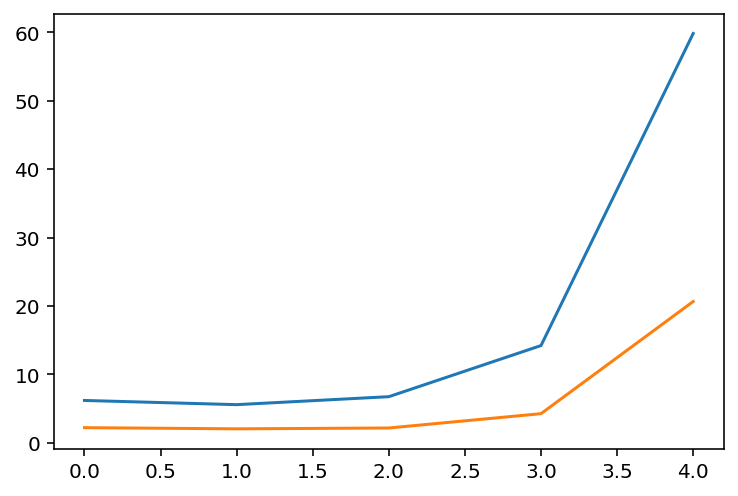

In [397]:
plot(L1_Q);
plot(L2_Q);

In [399]:
loss_Q

[1.1228628438611246e-20,
 2.098329632507648e-22,
 1.9450962704720819e-22,
 8.268826716864424e-20,
 2.3675047321267694e-17]